In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('./datasets/KRPUS_CNDAG/05e4d21a-31a0-3476-adf8-792558757ade.csv')
print(df.shape)
display(df.head(3))

(268, 12)


,VSL_ID,TIMESTAMP,SPEED,COG,HEADING,DRAFT,NAV_STATUS,LAT,LON,DESTINATION,UNLOCODE,ETA
0,05e4d21a-31a0-3476-adf8-792558757ade,2024-12-13 14:00:31,5.0,211.5,208.0,5.9,MOORED,35.120610,129.063040,CN DLC,CNDLC,2024-12-16 09:00:00
1,05e4d21a-31a0-3476-adf8-792558757ade,2024-12-13 14:10:02,8.8,124.6,124.0,5.9,UNDER_WAY_USING_ENGINE,35.103953,129.067067,CN DLC,CNDLC,2024-12-16 09:00:00
2,05e4d21a-31a0-3476-adf8-792558757ade,2024-12-13 14:20:51,9.2,125.7,125.0,5.9,UNDER_WAY_USING_ENGINE,35.087313,129.095240,CN DLC,CNDLC,2024-12-16 09:00:00


# 하이퍼 파라미터

In [31]:
TRAIN_SPLIT = 160  # (기본)len(df)*0.8
BATCH_SIZE = 18
EPOCH = 20
WEIGHT_UPDATE_INTERVAL = 11 #186 / 8 = 14...
VALIDATION_INTERVAL =  5 # (233 - TRAIN_SPLIT) // BATCH_SIZE
# BUFFER_SIZE = 230 #TRAIN_SPLIT과 같거나 큼

# 분석할 컬럼 추출 및 시간 데이터(형태변환, 시점개수)

In [33]:
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.sort_values('TIMESTAMP')
features = df[['TIMESTAMP','LAT','LON']]
features.set_index('TIMESTAMP', inplace=True)
display(features.head())
print(features.shape)

,LAT,LON
TIMESTAMP,,
2024-12-13 14:00:31,35.120610,129.063040
2024-12-13 14:10:02,35.103953,129.067067
2024-12-13 14:20:51,35.087313,129.095240
2024-12-13 14:30:21,35.071070,129.114053
2024-12-13 14:40:30,35.047667,129.129880


(268, 2)


In [35]:
# 소요시간
print('소요시간', df['TIMESTAMP'].max() - df['TIMESTAMP'].min())

소요시간 2 days 14:57:31


In [37]:
df['hour'] = df['TIMESTAMP'].dt.floor('H')         # 시간을 기준으로 자르기 (분/초 제거)

hourly_counts = df.groupby('hour').size()
print(np.round(hourly_counts.mean(), 2))
# 데이터 간 간격은 약 6분 간격 (60 / 10 = 6)

4.25


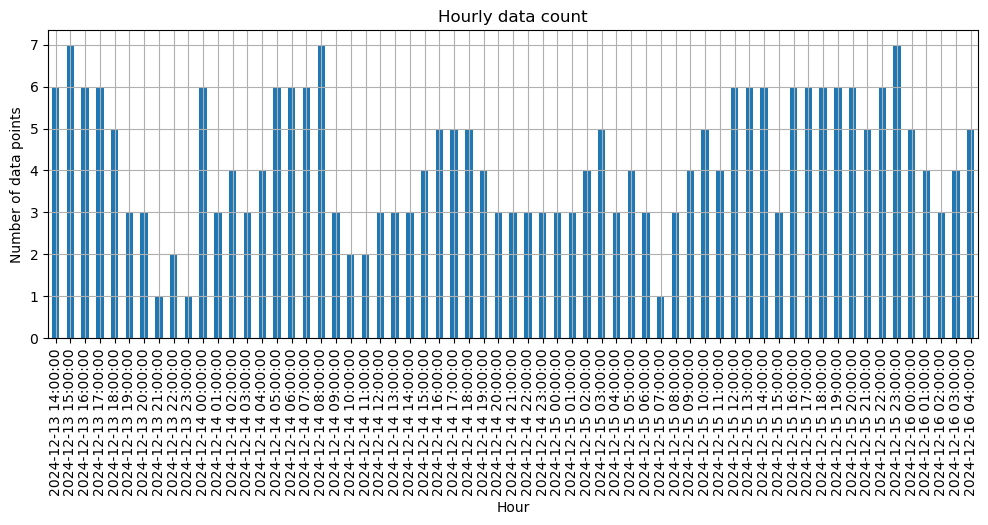

In [39]:
# (참고) 한 시간 당 데이터의 개수 확인 시각화
import matplotlib.pyplot as plt

hourly_counts.plot(kind='bar', figsize=(12, 4))
plt.title("Hourly data count")
plt.xlabel("Hour")
plt.ylabel("Number of data points")
plt.grid(True)
plt.show()

# 표준

In [41]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(features)

# 타임 스텝별 데이터 분리 함수

In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data, labels = [], []
    start_index += history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indexes = range(i - history_size, i, step)
        data.append(dataset[indexes])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i+target_size])

    return np.array(data), np.array(labels)

# 장기예측이므로 single_step=False

# 타임 스텝별 독립변수와 종속변수 추출

In [207]:
past_history = 40 #과거 4시간 (한 시간에 10개 * 4) # 숫자 수정 - 1시간에 10개니까 10단위로 끊어져야 함
future_target =15 #미래 1.5시간 (한 시간에 10개 * 1.5)
step = 1
# 선박의 총 소요시간을 파악 후 

X_train_single, y_train_single = multivariate_data(scaled, scaled, start_index=0, end_index=TRAIN_SPLIT, history_size=past_history, target_size=future_target, step=step, single_step=True)

X_val_single, y_val_single = multivariate_data(scaled, scaled, start_index=TRAIN_SPLIT, end_index=None, history_size=past_history, target_size=future_target, step=step, single_step=True)

In [146]:
print(X_train_single.shape) # shape[0]개의 학습 샘플, 각 샘플은 (LAT, LON)
print(y_train_single.shape) # shape[0]개의 미래 예측값, 10시점 예측값이 LAT/LON 포함되어 있음
print(X_val_single.shape) # 검증용 입력 22개 샘플, 각 샘플은 (LAT, LON)
print(y_val_single.shape)
# 검증용 데이터 생성 안될 시, TRAIN_SPLIT = len(scaled) - (past_history + future_target) 값 변경

(120, 40, 2)
(120, 2)
(53, 40, 2)
(53, 2)


# 학습 및 평가 데이터 생성

In [149]:
train_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single)).cache().shuffle(X_train_single.shape[0]).batch(BATCH_SIZE, drop_remainder=True).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single)).cache().shuffle(X_train_single.shape[0]).batch(BATCH_SIZE, drop_remainder=True).repeat()

# LSTM 모델 생성 및 학습

In [151]:
single_step_model = Sequential()
single_step_model.add(LSTM(64, input_shape=X_train_single.shape[-2:]))
# single_step_model.add(LSTM(32, activation='relu'))
single_step_model.add(Dense(2))
# single_step_model.add(Reshape(((future_target, 2))))
single_step_model.compile(optimizer='adam', loss='mse') #WGA

In [153]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCH, steps_per_epoch=WEIGHT_UPDATE_INTERVAL, validation_data=val_data_single, validation_steps=VALIDATION_INTERVAL, callbacks=[early_stop])

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0796 - val_loss: 0.0226
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0165 - val_loss: 0.0039
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0011 - val_loss: 8.9383e-04
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 9.1061e-04 - val_loss: 8.7309e-04
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1106e-04 - val_loss: 7.2624e-04
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.4412e-04 - val_loss: 8.0812e-04
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.1552e-04 - val_loss: 6.7387e-04
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.0474e-04 - val_loss: 7.8295e-04
Epoch 12/20
11/11 ━

# 예측 결과 시각화 함수

In [156]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    past_history = range(-len(history), 0)
    future = len(true_future)

    plt.plot(past_history, history, '.-', label='History')
    plt.plot(np.arange(future) / 5, true_future, 'ro', label='True_future')
    plt.plot(np.arange(future) /  5, prediction, 'go', label='Predicted_future')
    plt.legend()
    plt.xlabel('Time-Step')
    plt.grid(True)
    plt.show()

# 역정규화 함수 & 시각화 함수 사용

In [158]:
# 역정규화 함수
def inverse_coords(arr_3d, scaler):
    flat = arr_3d.reshape(-1, 2)
    inv = scaler.inverse_transform(flat)
    return inv.reshape(arr_3d.shape)

# 시각화 함수 사용
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    past_history = range(-len(history), 0)
    future = len(true_future)

    plt.plot(past_history, history, '.-', label='History')
    plt.plot(np.arange(future) / 5, true_future, 'ro', label='True_future')
    plt.plot(np.arange(future) /  5, prediction, 'go', label='Predicted_future')
    plt.legend()
    plt.xlabel('Time-Step')
    plt.grid(True)
    plt.show()

# 전체 경로 그리기

In [160]:
def plot_path(actual_path, pred_path):
    plt.figure(figsize=(8,5))
    plt.plot(actual_path[:,1], actual_path[:,0], 'r', label='actual path')
    plt.plot(pred_path[:,1], pred_path[:,0], 'b', label='pred path')
    plt.legend()
    plt.grid(True)
    plt.show()

## 전체 데이터에 대한 분할

In [162]:
X_, y_ = multivariate_data(scaled, scaled, start_index=0, end_index=None, history_size=past_history, target_size=future_target, step=step, single_step=True)

## 전체 경로에 대한 예측 경로 / 실제 경로
- 실제 경로: actual_path
- 예측 경로: pred_path

In [164]:
actual_path = features.values
pred_path = single_step_model.predict(X_)
pred_path = inverse_coords(pred_path, scaler)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [165]:
pred_path.shape, actual_path.shape

((213, 2), (268, 2))

# 지도에 시각화

In [167]:
# 실제 경로
import folium
from folium import PolyLine

true_coords = list(zip(df['LAT'], df['LON']))
center_lat = df['LAT'].mean()
center_lon = df['LON'].mean()

# 지도 객체 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# 실제 경로 선 그리기
folium.PolyLine(true_coords, color='red', weight=4, tooltip='Actual Path').add_to(m)

# 예측 경로 선 그기기
pred_path = np.array(pred_path)
#print(pred_path)
folium.PolyLine(pred_path, color='green', weight=4, tooltip='Predicted Path').add_to(m)

# 지도 실행
display(m)

# 결정계수 확인

In [169]:
from sklearn.metrics import r2_score

print('LAT R2-Score:%.3f'%r2_score(actual_path[55:,0], pred_path[:,0]))
print('LON R2-Score:%.3f'%r2_score(actual_path[55:,1], pred_path[:,1]))
# actual_path[X:,0] -> X: past_history + future_target

LAT R2-Score:0.966
LON R2-Score:0.966


# 모델 저장

In [172]:
single_step_model.save('CNDAG_model.keras')

# 오차 계산 및 시각화 함수

In [175]:
import numpy as np
import matplotlib.pyplot as plt

def plot_prediction_errors(actual_path, pred_path):
    """
    실제값(actual_path)과 예측값(pred_path)을 비교하여 오차 시각화
    - actual_path, pred_path: shape (N, 2) [LAT, LON]
    """
    # 1. 오차 계산
    offset = len(actual_path) - len(pred_path)
    actual_aligned = actual_path[offset:]  # 실제 경로 뒤쪽 자르기 (예측에 맞춤)

    # actual_path와 pred_path 길이 맞춰 오차 계산
    lat_error = actual_aligned[:, 0] - pred_path[:, 0]
    lon_error = actual_aligned[:, 1] - pred_path[:, 1]
    total_error = np.sqrt(lat_error**2 + lon_error**2)  # 유클리드 거리 (단위: degree)

    # 2. 시각화
    plt.figure(figsize=(12, 4))

    # ✅ y축 범위 통일을 위한 최대/최소 계산
    y_min = min(lat_error.min(), lon_error.min(), total_error.min())
    y_max = max(lat_error.max(), lon_error.max(), total_error.max())

    plt.subplot(1, 3, 1)
    plt.plot(lat_error, label='Latitude Error', color='orange')
    plt.ylim(y_min, y_max)
    plt.title('Latitude Error')
    plt.xlabel('Sample Index')
    plt.ylabel('Error (deg)')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(lon_error, label='Longitude Error', color='green')
    plt.ylim(y_min, y_max)
    plt.title('Longitude Error')
    plt.xlabel('Sample Index')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(total_error, label='Total Position Error', color='red')
    plt.ylim(y_min, y_max)
    plt.title('Total Distance Error (deg)')
    plt.xlabel('Sample Index')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 4. 평균 오차 (° 단위)
    mean_lat_error = np.mean(np.abs(lat_error))
    mean_lon_error = np.mean(np.abs(lon_error))
    mean_total_error = np.mean(total_error)

    # 5. 평균 오차 (km 단위)
    avg_lat_rad = np.radians(np.mean(actual_path[:, 0]))  # 평균 위도 → 라디안
    km_lat_error = mean_lat_error * 111  # 위도는 고정
    km_lon_error = mean_lon_error * 111 * np.cos(avg_lat_rad)  # 경도는 위도에 따라 조정
    km_total_error = mean_total_error * 111

    # 3. 평균 오차 출력
    print(f"평균 LAT(위도) 오차 범위: {mean_lat_error:.2f}° (약 {km_lat_error:.2f}km)")
    print(f"평균 LON(경도) 오차 범위: {mean_lon_error:.2f}° (약 {km_lon_error:.2f}km)")
    print(f"평균 전체 위치 오차 범위: {mean_total_error:.2f}° (약 {km_total_error:.2f}km)")

    return lat_error, lon_error, total_error

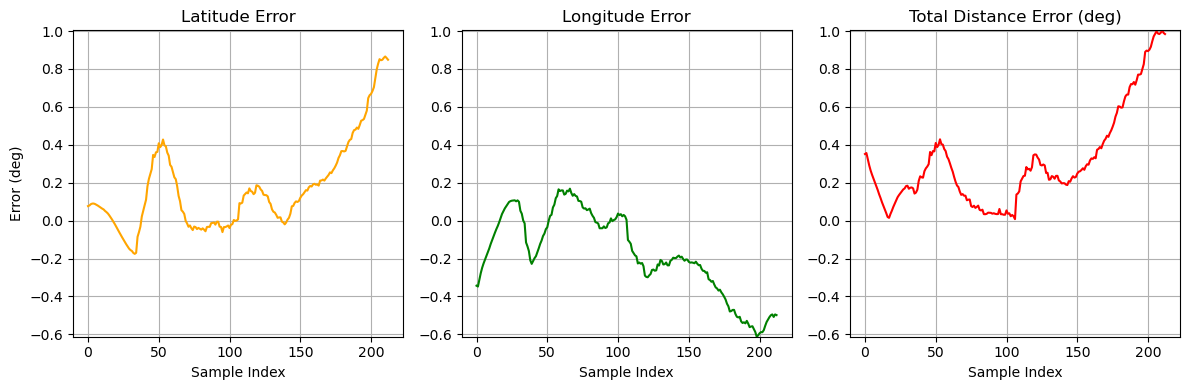

평균 LAT(위도) 오차 범위: 0.20° (약 22.12km)
평균 LON(경도) 오차 범위: 0.22° (약 19.60km)
평균 전체 위치 오차 범위: 0.31° (약 34.48km)


In [176]:
lat_err, lon_err, total_err = plot_prediction_errors(actual_path, pred_path)
# LAT(위도): y값 = 위도오차 (예측값-실제값) / 위로 가면 북쪽, 아래로 가면 남쪽
# LON(경도): y값 = 경도오차 (예측값-실제값) / 왼쪽으로 가면 서쪽, 오른쪽으로 가면 동쪽
# 평균 전체: LAT+LON 오차를 유클리드 거리로 계산, 값이 작을수록 모델이 정확히 예측

# 모델 불러오기

In [181]:
from tensorflow.keras.models import load_model

model = load_model('CNDAG_model.keras')

# 다른 파일(선박) 로딩 / 모델에 적용

In [183]:
# 시퀀스 생성 함수
import numpy as np

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data, labels = [], []
    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [184]:
# 예측 수행 함수
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def predict_from_file(csv_path, model_path, past_history=30, future_target=10, step=1):

    # 1. CSV 불러오기
    df = pd.read_csv(csv_path)
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df = df.sort_values('TIMESTAMP')
    features = df[['LAT', 'LON']].copy()

    # 2. 스케일링
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # 3. 전체 데이터에 대한 분할 (시퀀스 생성)
    X_, y_ = multivariate_data(features_scaled, features_scaled,
                              start_index=0, end_index=None,
                              history_size=past_history,
                              target_size=future_target,
                              step=step,
                              single_step=True)

    # 4. 모델 불러오기 & 예측
    model = load_model(model_path)
    y_pred_scaled = model.predict(X_)

    # 5. 역정규화
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_)

    # 6. R² 계산
    r2_lat = r2_score(y_true[:, 0], y_pred[:, 0])
    r2_lon = r2_score(y_true[:, 1], y_pred[:, 1])

    print(f"📈 LAT R²: {r2_lat:.4f}")
    print(f"📈 LON R²: {r2_lon:.4f}")

    # 7. 전체 실제 경로도 반환
    true_path = features.values

    return true_path, y_pred, df

In [187]:
# 지도 시각화 함수
import folium
from IPython.display import display

def plot_paths_on_map(true_path, pred_path, df):
    # 좌표 float 변환
    true_coords = [(float(lat), float(lon)) for lat, lon in true_path]
    pred_coords = [(float(lat), float(lon)) for lat, lon in pred_path]

    # 지도 중심
    center_lat = df['LAT'].mean()
    center_lon = df['LON'].mean()

    m = folium.Map(location=[center_lat, center_lon], zoom_start=9)
    folium.PolyLine(true_coords, color='red', weight=4, tooltip='Actual Path').add_to(m)
    folium.PolyLine(pred_coords, color='green', weight=4, tooltip='Predicted Path').add_to(m)
    m.fit_bounds(true_coords + pred_coords)

    display(m)

## 모델에 적용 / 시각화

In [191]:
# (1) 첫 번째 선박으로 모델을 생성, 두 번째 선박에 적용
# 1. 예측 실행
true_path, pred_path, df = predict_from_file(
    './datasets/KRPUS_CNDAG/42c578a0-ce4c-3cf7-977e-ece463542581.csv',
    'CNDAG_model.keras'
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
📈 LAT R²: 0.9748
📈 LON R²: 0.9421


In [209]:
# 지도에 그리기
plot_paths_on_map(true_path, pred_path, df)

In [194]:
# (1) 첫 번째 선박으로 모델을 생성, 세 번째 선박에 적용
# 1. 예측 실행
true_path, pred_path, df = predict_from_file(
    './datasets/KRPUS_CNDAG/a804036f-9377-3242-a11d-1b76dfa0dcec.csv',
    'CNDAG_model.keras'
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
📈 LAT R²: 0.9446
📈 LON R²: 0.9686


- 파일명 변경
- 결정 계수 변경 (과거, 미래 시점)